In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from tqdm import tqdm, trange
from PIL import Image
from sklearn.manifold import TSNE
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

from segment.utils import loadModel, segment

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "output/"
EMB_SIZE = 64
EMB_MODEL_PATH = os.path.join("models", "embedding_model.pt")

SIGMA = 0.007
K_RESULTS = 10

get_output_path = lambda path: os.path.join(OUTPUT_DIR, path)

print(f"DEVICE = {DEVICE}")

np.random.seed(SEED)
torch.manual_seed(SEED);

DEVICE = cuda


In [2]:
def mask_inputs(image):
    rl_mask, ll_mask, h_mask = segment(image / 255., segmodel, device=DEVICE)
    return (image * (rl_mask | ll_mask | h_mask).astype(int) / 255.).astype(np.float32)

In [3]:
segmodel = loadModel(os.path.join("models", "weights.pt"), DEVICE)
embmodel = torch.load(EMB_MODEL_PATH)

preprocess_transform = transforms.Compose([transforms.Grayscale(),
                                           np.asarray,
                                           mask_inputs,
                                           transforms.ToPILImage(),
                                           transforms.Grayscale(3),
                                           transforms.Resize((112, 112)),
                                           transforms.ToTensor()])

In [4]:
class ImageFolderWithPaths(ImageFolder):
    # https://stackoverflow.com/questions/71267824/getting-image-path-through-a-torchvision-dataloader-using-local-images
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        path = self.imgs[index][0]
        return img, label, path


SUBSET_SIZE = 500

rng = np.random.RandomState(seed=SEED + 3)

dataset = ImageFolderWithPaths(os.path.join("data", "train"), transform=preprocess_transform)
subdataset = Subset(dataset, rng.choice(len(dataset), SUBSET_SIZE, replace=False))
dl = DataLoader(subdataset, batch_size=128, shuffle=False, pin_memory=True)

dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

In [5]:
# query_image_path = os.path.join("data", "train", "PNEUMONIA", "person24_bacteria_111.jpeg")
query_image_path = os.path.join("data", "train", "NORMAL", "IM-0182-0001.jpeg")
# query_image_path = "sample.jpeg"

with torch.no_grad():
    query_vec = embmodel(preprocess_transform(Image.open(query_image_path)).unsqueeze(dim=0)).logits

C:\Users\Wei Min\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


100%|██████████| 4/4 [00:25<00:00,  6.27s/it]


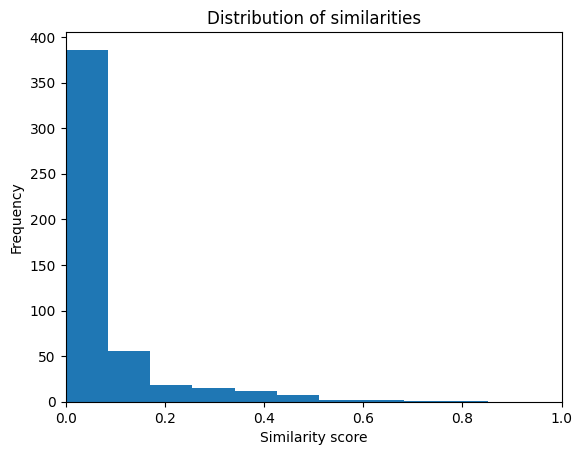

In [6]:
embmodel.to(DEVICE)
embmodel.eval()
query_vec = query_vec.to(DEVICE)

image_paths = list()
similarities = list()
all_labels = list()
all_embs = list()

with torch.no_grad():
    for img, label, path in tqdm(dl, total=len(dl)):
        key_vec = embmodel(img.to(DEVICE)).logits
        distance = torch.linalg.norm(query_vec - key_vec, dim=-1)
        sim = torch.exp(-distance / (2 * SIGMA ** 2))

        image_paths.extend(path)
        similarities.extend(sim.cpu().tolist())
        all_labels.extend(label.tolist())
        all_embs.extend(key_vec.cpu().tolist())

image_paths = np.array(image_paths)
similarities = np.array(similarities)
all_labels = np.array(all_labels)

top_K_idx = np.argsort(similarities)[::-1][:K_RESULTS]

result_img_paths = image_paths[top_K_idx]
result_sim = similarities[top_K_idx]
result_label = all_labels[top_K_idx]
all_embs = np.array(all_embs)

embmodel.cpu()
query_vec = query_vec.cpu()

plt.hist(similarities)
plt.title("Distribution of similarities")
plt.xlabel("Similarity score")
plt.ylabel("Frequency")
plt.xlim(0, 1);

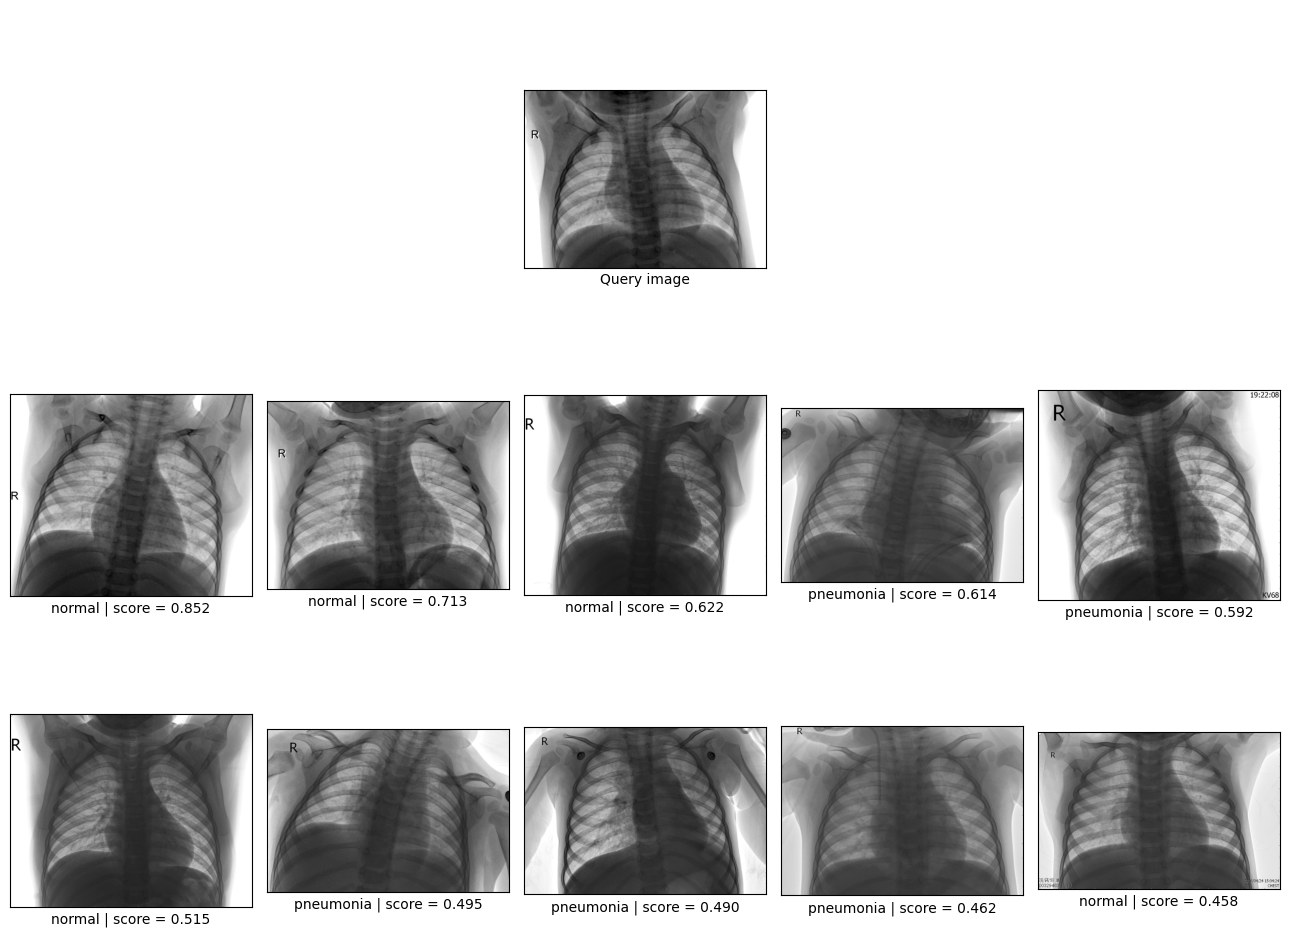

In [23]:
NUM_ROWS = 2
NUM_COLS = 5

assert NUM_ROWS * NUM_COLS == K_RESULTS

_, axs = plt.subplots(NUM_ROWS + 1, NUM_COLS, figsize=(13, 10))

ax = axs[0, NUM_COLS // 2]
ax.imshow(cv2.imread(query_image_path, 0) / 255., "binary")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
for i in range(NUM_COLS):
    if i != NUM_COLS // 2:
        axs[0, i].axis("off")
ax.set_xlabel("Query image")

for i, (fp, sim, label) in enumerate(zip(result_img_paths, result_sim, result_label), NUM_COLS):
    img = cv2.imread(fp, 0) / 255.
    diagnosis = "pneumonia" if label == 1 else "normal"

    ax = axs[i // NUM_COLS, i % NUM_COLS]
    ax.imshow(img, "binary")
    ax.set_xlabel(f"{diagnosis} | score = {sim:.3f}")

    ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

plt.tight_layout()

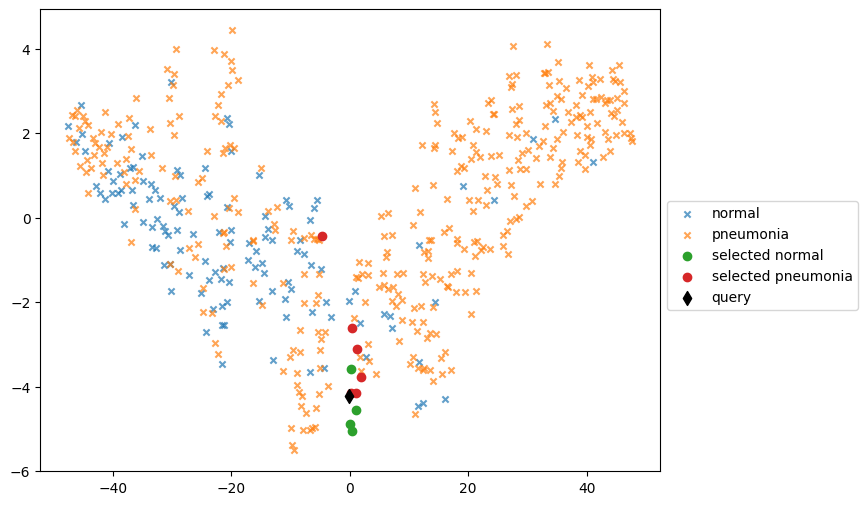

In [54]:
emb_red = TSNE(perplexity=35).fit_transform(np.concatenate([all_embs, query_vec]))
emb_query = emb_red[[-1]]
emb_red = emb_red[:-1]

plt.figure(figsize=(8, 6))

emb_red_distant = np.delete(emb_red, top_K_idx, axis=0)
labels_distant = np.delete(all_labels, top_K_idx)

plt.scatter(*emb_red_distant[labels_distant == 0].T, marker="x", s=20, alpha=0.7, label="normal")
plt.scatter(*emb_red_distant[labels_distant == 1].T, marker="x", s=20, alpha=0.7, label="pneumonia")
plt.scatter(*emb_red[top_K_idx][labels_distant[top_K_idx] == 0].T, c="tab:green", label="selected normal")
plt.scatter(*emb_red[top_K_idx][labels_distant[top_K_idx] == 1].T, c="tab:red", label="selected pneumonia")
plt.scatter(*emb_query.T, marker="d", c="k", s=50, label="query")

plt.legend(bbox_to_anchor=(1, 0.6));